In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

In [2]:
PATH = 'KITTI_unet/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)    
    
    # resize
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # copy
    gray = tf.identity(image)
    color= tf.identity(image)
    
    # convert to gray
    gray = tf.image.rgb_to_grayscale(gray)
    
    gray  = tf.cast(gray, tf.float32)
    color = tf.cast(color, tf.float32) 

    return gray, color

2023-01-15 12:21:03.224570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 12:21:03.228410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 12:21:03.228508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 12:21:03.251302: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

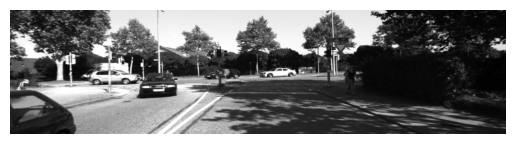

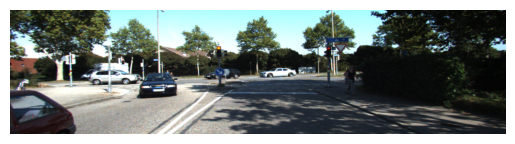

In [3]:
gray, color = load(PATH+'training/000008_10.png')

# casting to int for matplotlib to show the image
plt.figure()
plt.axis('off')
plt.imshow(gray[:,:,0]/255.0, cmap='gray')

plt.figure()
plt.axis('off')
plt.imshow(color/255.0)

In [4]:
# normalizing the images to [-1, 1]
def normalize(gray, color):
    gray  = (gray / 127.5) - 1
    color = (color / 127.5) - 1

    return gray, color

def random_jitter(gray, color):
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        gray  = tf.image.flip_left_right(gray)
        color = tf.image.flip_left_right(color)

    return gray, color

def load_image_train(image_file):
    gray, color = load(image_file)
    gray, color = random_jitter(gray, color)
    gray, color = normalize(gray, color)

    return gray, color

def load_image_test(image_file):
    gray, color = load(image_file)
    gray, color = normalize(gray, color)

    return gray, color

In [5]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'training/0000*_10.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'testing/0000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [16]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Gray Image', 'True Color Image', 'Predicted Color Image']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i==0:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')        
        else:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

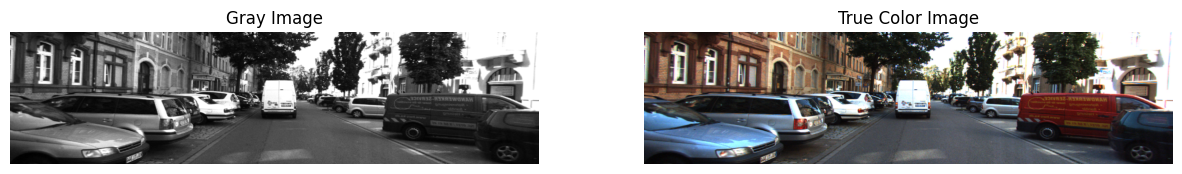

In [23]:
for gray, color in train_dataset.take(1):    
    sample_gray, sample_color = gray[0], color[0]
    display([sample_gray, sample_color])

In [29]:
inputs = tf.keras.layers.Input(shape=[256, 1024, 1])    
x = inputs  

# block 1
x = tf.keras.layers.Conv2D(64, 4, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre1 = x

# block 2
x = tf.keras.layers.Conv2D(128, 4, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre2 = x

# block 3
x = tf.keras.layers.Conv2D(256, 4, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre3 = x

# block 4
x = tf.keras.layers.Conv2D(512, 4, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre4 = x

# block 5
x = tf.keras.layers.Conv2D(512, 4, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# upsampling
x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre4])

# upsampling
x = tf.keras.layers.Conv2DTranspose(256, 4, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre3])

# upsampling
x = tf.keras.layers.Conv2DTranspose(128, 4, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre2])

# upsampling
x = tf.keras.layers.Conv2DTranspose(64, 4, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre1])

# upsampling
x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)

model = tf.keras.Model(inputs=[inputs], outputs=[x])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 1024,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 256, 1024, 6  1088        ['input_4[0][0]']                
                                4)                                                                
                                                                                                  
 batch_normalization_27 (BatchN  (None, 256, 1024, 6  256        ['conv2d_15[0][0]']              
 ormalization)                  4)                                                          

 add_15 (Add)                   (None, 128, 512, 64  0           ['batch_normalization_35[0][0]', 
                                )                                 'max_pooling2d_15[0][0]']       
                                                                                                  
 conv2d_transpose_19 (Conv2DTra  (None, 256, 1024, 3  3075       ['add_15[0][0]']                 
 nspose)                        )                                                                 
                                                                                                  
Total params: 13,909,891
Trainable params: 13,905,027
Non-trainable params: 4,864
__________________________________________________________________________________________________


In [34]:
model.predict(sample_gray[tf.newaxis, ...]).shape

2023-01-15 12:46:03.521954: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-15 12:46:04.099357: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 12:46:04.099777: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 12:46:04.099795: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-15 12:46:04.100177: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 12:46:04.100223: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(1, 256, 1024, 3)

In [36]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

def show_predictions(dataset=None, num=1):
    predicted_image = model.predict(sample_gray[tf.newaxis, ...])
    display([sample_gray, sample_color, predicted_image[0]])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0110

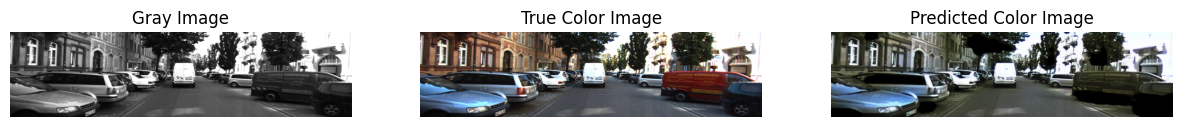


Sample Prediction after epoch 1

100/100 [==============================] - 5s 42ms/step - loss: 0.0110
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0098

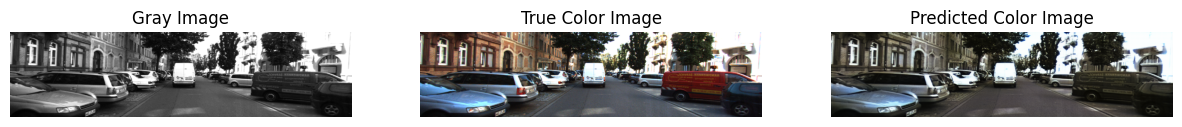


Sample Prediction after epoch 2

100/100 [==============================] - 4s 40ms/step - loss: 0.0098
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0099

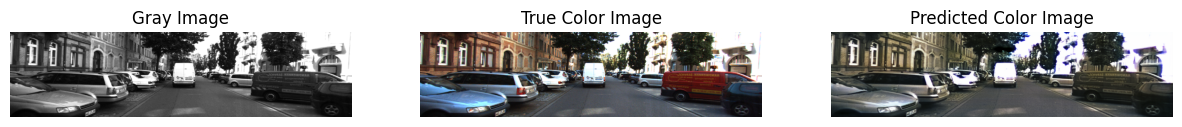


Sample Prediction after epoch 3

100/100 [==============================] - 4s 41ms/step - loss: 0.0100
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0108

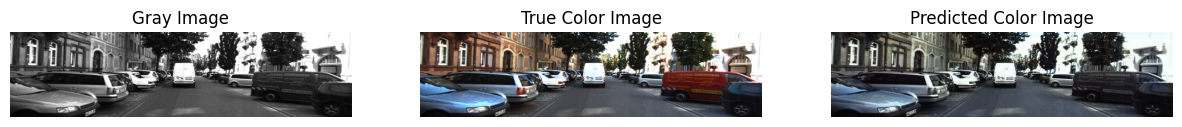


Sample Prediction after epoch 4

100/100 [==============================] - 4s 39ms/step - loss: 0.0108
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 0.0116

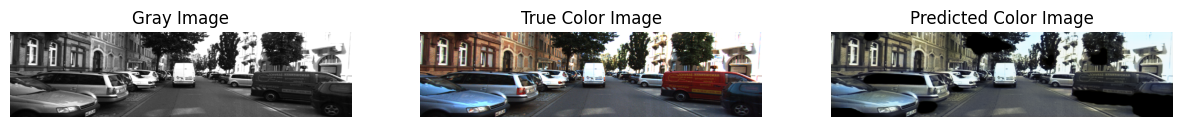


Sample Prediction after epoch 5

100/100 [==============================] - 4s 39ms/step - loss: 0.0116
Epoch 6/20
100/100 [==============================] - ETA: 0s - loss: 0.0107

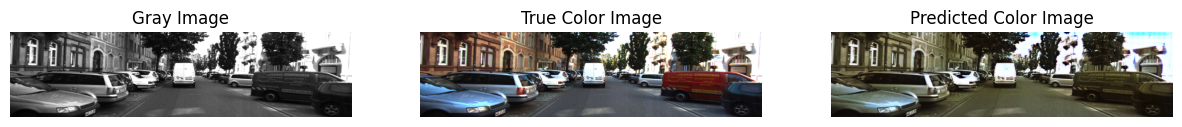


Sample Prediction after epoch 6

100/100 [==============================] - 4s 39ms/step - loss: 0.0107
Epoch 7/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0102

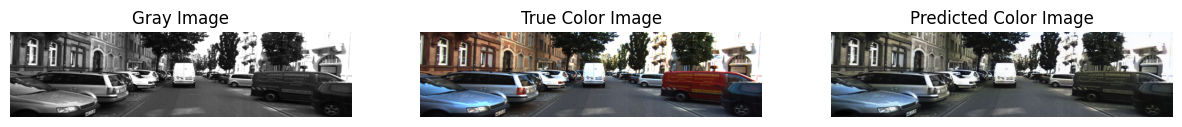


Sample Prediction after epoch 7

100/100 [==============================] - 4s 39ms/step - loss: 0.0101
Epoch 8/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0103

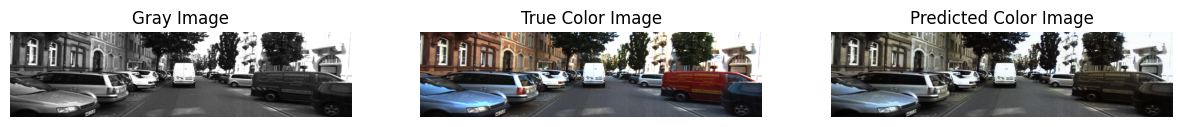


Sample Prediction after epoch 8

100/100 [==============================] - 4s 39ms/step - loss: 0.0102
Epoch 9/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0094

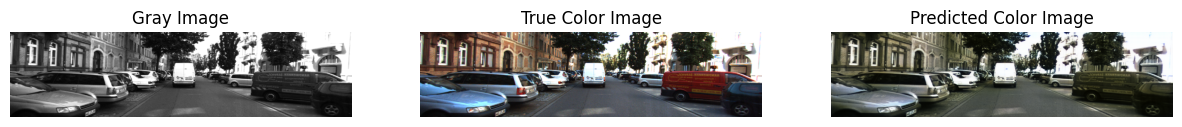


Sample Prediction after epoch 9

100/100 [==============================] - 4s 39ms/step - loss: 0.0094
Epoch 10/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0092

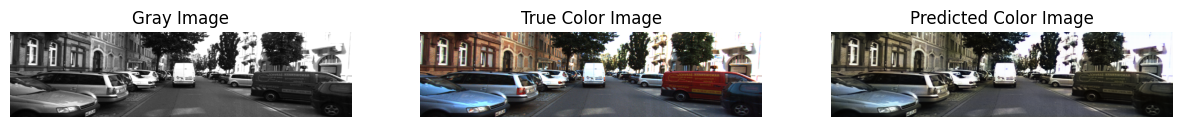


Sample Prediction after epoch 10

100/100 [==============================] - 4s 40ms/step - loss: 0.0092
Epoch 11/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0103

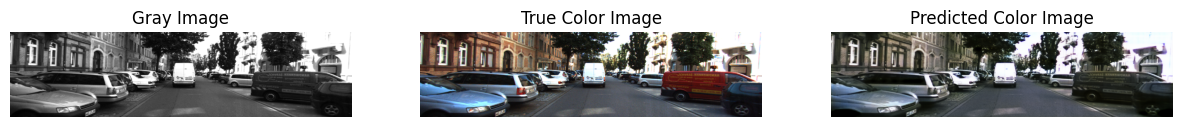


Sample Prediction after epoch 11

100/100 [==============================] - 4s 40ms/step - loss: 0.0103
Epoch 12/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0097

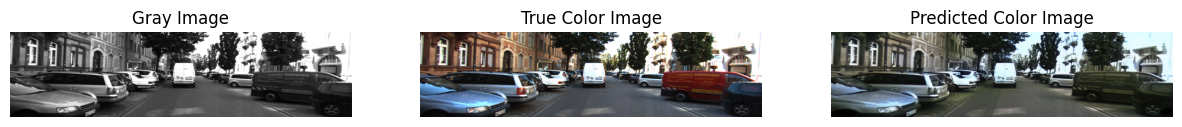


Sample Prediction after epoch 12

100/100 [==============================] - 4s 39ms/step - loss: 0.0097
Epoch 13/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0093

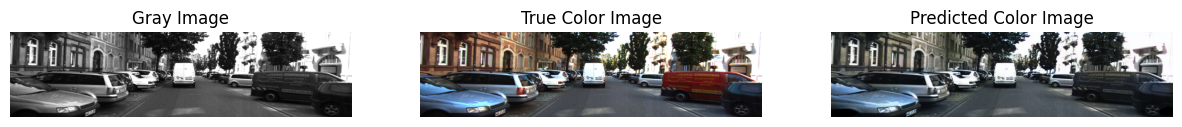


Sample Prediction after epoch 13

100/100 [==============================] - 4s 40ms/step - loss: 0.0094
Epoch 14/20
100/100 [==============================] - ETA: 0s - loss: 0.0095

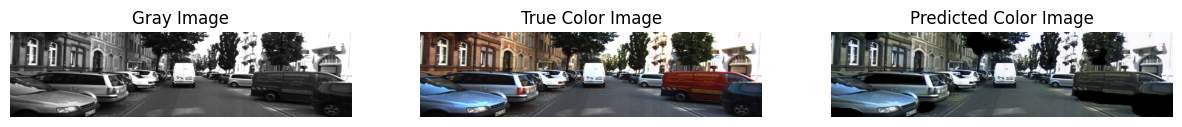


Sample Prediction after epoch 14

100/100 [==============================] - 4s 40ms/step - loss: 0.0095
Epoch 15/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0100

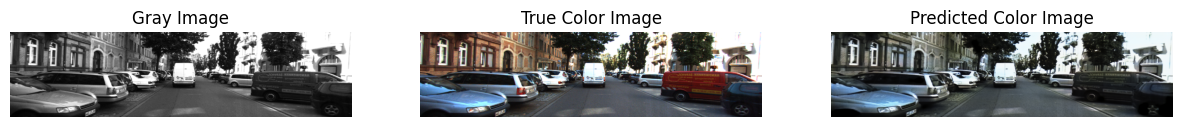


Sample Prediction after epoch 15

100/100 [==============================] - 4s 40ms/step - loss: 0.0100
Epoch 16/20
100/100 [==============================] - ETA: 0s - loss: 0.0105

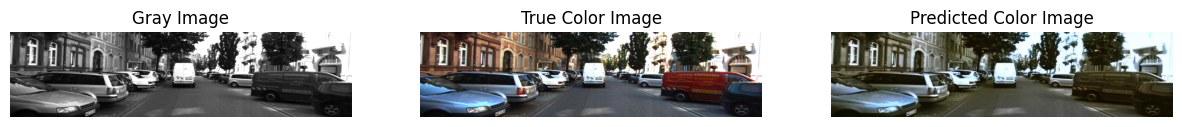


Sample Prediction after epoch 16

100/100 [==============================] - 4s 39ms/step - loss: 0.0105
Epoch 17/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0101

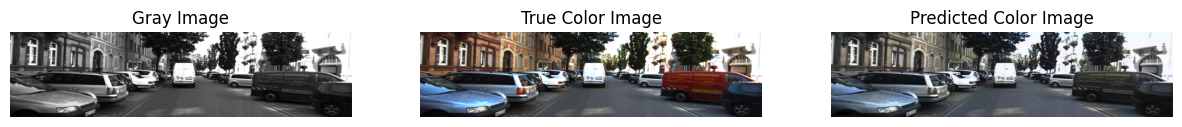


Sample Prediction after epoch 17

100/100 [==============================] - 4s 39ms/step - loss: 0.0101
Epoch 18/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0087

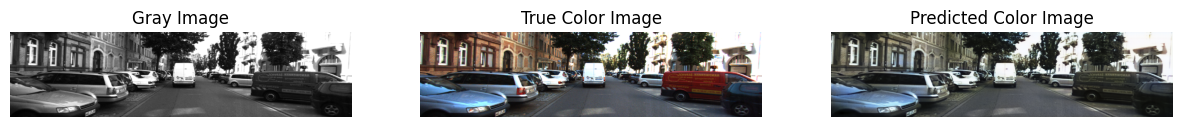


Sample Prediction after epoch 18

100/100 [==============================] - 4s 40ms/step - loss: 0.0087
Epoch 19/20
100/100 [==============================] - ETA: 0s - loss: 0.0084

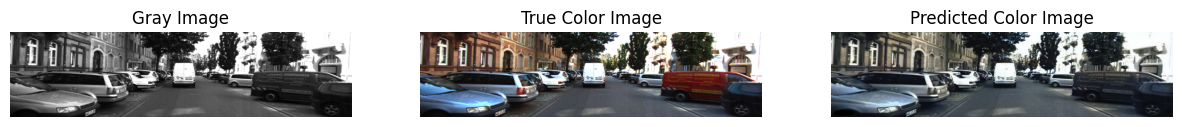


Sample Prediction after epoch 19

100/100 [==============================] - 4s 41ms/step - loss: 0.0084
Epoch 20/20
100/100 [==============================] - ETA: 0s - loss: 0.0099

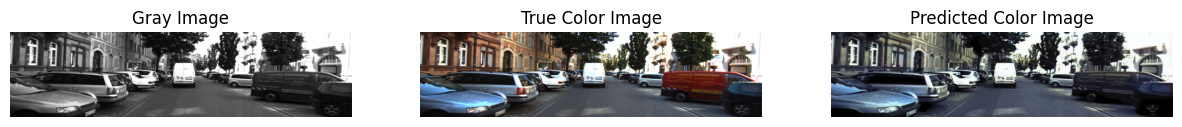


Sample Prediction after epoch 20


100/100 [==============================] - 4s 39ms/step - loss: 0.0099


In [41]:
tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

EPOCHS = 20

model_history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[DisplayCallback()])

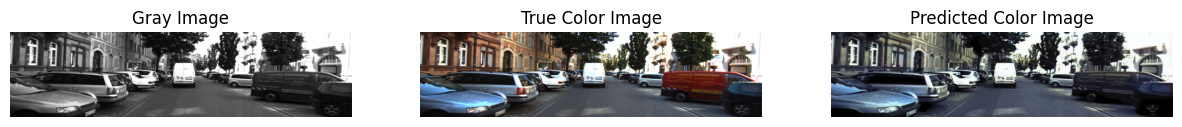

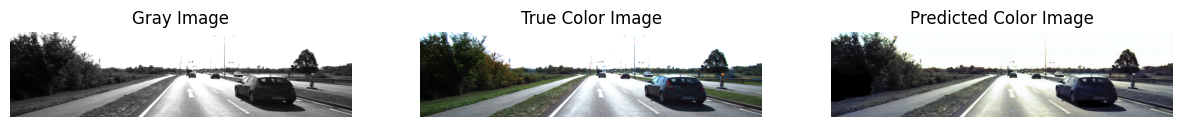

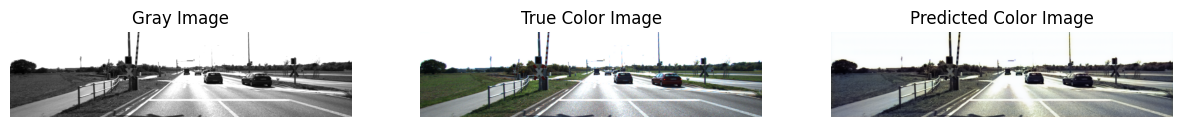

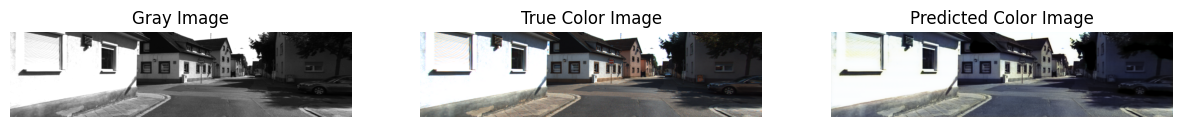

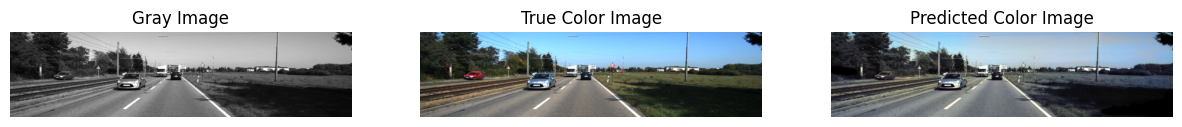

In [49]:
for gray_image, color_image in train_dataset.take(5):
    predicted_image = model.predict(gray_image)
    display([gray_image[0], color_image[0], predicted_image[0]])